In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('./CDNOW.txt',sep='\s+',names=['id','date','quantity','amount'])
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
data.describe()

,id,date,quantity,amount
count,69659.000000,6.965900e+04,69659.000000,69659.000000
mean,11470.854592,1.997228e+07,2.410040,35.893648
std,6819.904848,3.837735e+03,2.333924,36.281942
min,1.000000,1.997010e+07,1.000000,0.000000
25%,5506.000000,1.997022e+07,1.000000,14.490000
50%,11410.000000,1.997042e+07,2.000000,25.980000
75%,17273.000000,1.997111e+07,3.000000,43.700000
max,23570.000000,1.998063e+07,99.000000,1286.010000


1. 用户平均每笔订单购买数是2.4，中位数是2，最大值达到99，数据分布右偏，存在异常值；
2. 同样的购买金额平均消费35.89，中位数25.98，最大1286，数据分布右偏，存在异常值。

In [3]:
print(pd.isnull(data).sum())

id          0
date        0
quantity    0
amount      0
dtype: int64


没有缺失值，若有缺失值，可以填充或抛弃
1. 填充：data.fillna(1,inplace=True)
2. 抛弃：data.dropna(how='any')

# 一. 以时间分群，订单数量以及金额趋势分析

In [4]:
data['date'] = pd.to_datetime(data['date'],format='%Y%m%d')  
data = data.set_index('date',drop=True) #设置date为新索引，在源数据中drop掉date
month_grouped = data.resample('m').agg({'id':'count','quantity':'sum','amount':'sum'})#降采样，频率：月
month_grouped['user_sum']=data.resample('m')['id'].nunique()
print(month_grouped)

               id  quantity     amount  user_sum
date                                            
1997-01-31   8928     19416  299060.17      7846
1997-02-28  11272     24921  379590.03      9633
1997-03-31  11598     26159  393155.27      9524
1997-04-30   3781      9729  142824.49      2822
1997-05-31   2895      7275  107933.30      2214
1997-06-30   3054      7301  108395.87      2339
1997-07-31   2942      8131  122078.88      2180
1997-08-31   2320      5851   88367.69      1772
1997-09-30   2296      5729   81948.80      1739
1997-10-31   2562      6203   89780.77      1839
1997-11-30   2750      7812  115448.64      2028
1997-12-31   2504      6418   95577.35      1864
1998-01-31   2032      5278   76756.78      1537
1998-02-28   2026      5340   77096.96      1551
1998-03-31   2793      7431  108970.15      2060
1998-04-30   1878      4697   66231.52      1437
1998-05-31   1985      4903   70989.66      1488
1998-06-30   2043      5287   76109.30      1506


1. 消费人群集中在前三月，从1997年4月开始都很平稳
2. 前三个月消费人数在8000-10000之间，但后面的大概在2000，说明用户粘性不足

In [6]:
data.drop_duplicates('id')['id'].resample('m').count() #先把id去重，即每个用户只保留第一次购买记录，再统计每月消费人数与前面的消费人数比较

date
1997-01-31    7846
1997-02-28    8476
1997-03-31    7248
Freq: M, Name: id, dtype: int64

3. 可以发现1997年4月以及后面的月份都没有记录，说明没有新用户购买，说明上面的消费人数大概在2000左右是由前三月份用户回购行为产生

# 二. 以用户分群，用户消费行为静态分析

In [7]:
user_grouped = data.groupby('id').agg({'id':'count', 'quantity':'sum','amount':'sum'})
user_grouped.describe()

,id,quantity,amount
count,23570.000000,23570.000000,23570.000000
mean,2.955409,7.122656,106.080426
std,4.736558,16.983531,240.925195
min,1.000000,1.000000,0.000000
25%,1.000000,1.000000,19.970000
50%,1.000000,3.000000,43.395000
75%,3.000000,7.000000,106.475000
max,217.000000,1033.000000,13990.930000


1. 用户平均消费次数是2.95次，然而1/4和中位数都是1，说明大部分用户只在该网站消费了1次
2. 购买数量和金额的平均值等于其3/4分位数，说明少量用户购买大量产品，直方图偏右

## 用户购买数量分析以及购买金额分析

In [8]:
user_grouped[['quantity','amount']].head()

,quantity,amount
id,,
1,1,11.77
2,6,89.00
3,16,156.46
4,7,100.50
5,29,385.61


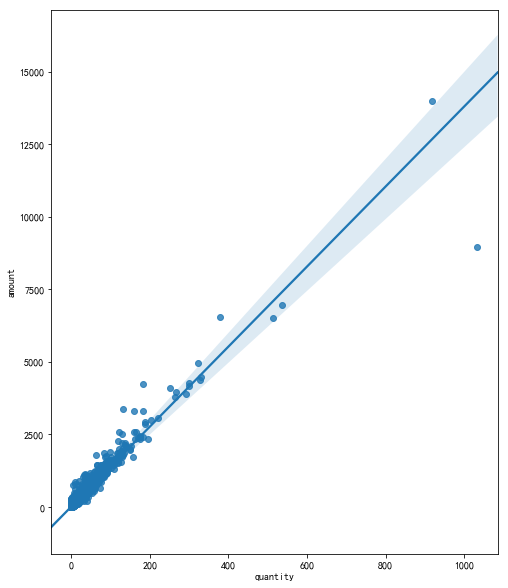

In [9]:
import seaborn as sns
sns.regplot('quantity','amount',data=user_grouped)

从散点图很明显可以看出右上角有两个异常值，滤除掉

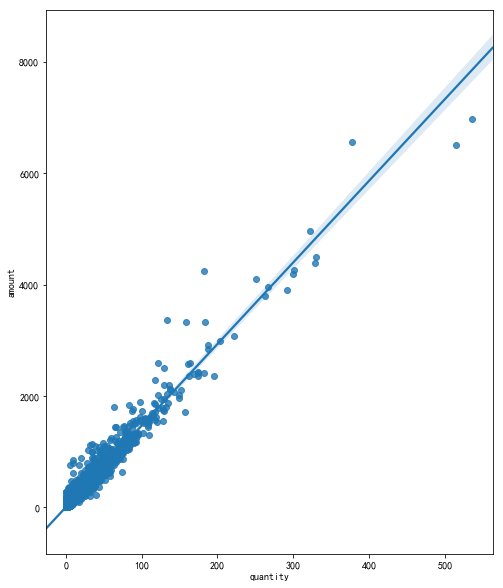

In [10]:
sns.regplot('quantity','amount',data=user_grouped.query('quantity<600'))

可以看到拟合出一条直线，说明单价稳定

## 各用户累积消费金额分布图

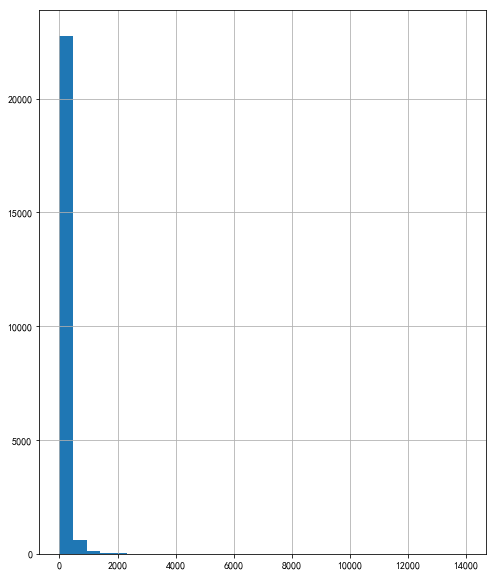

In [13]:
user_grouped['amount'].hist(bins=30)
#sns.distplot(user_grouped['amount'],bins=30,color='k') 直方图和密度图

## 滤除异常值

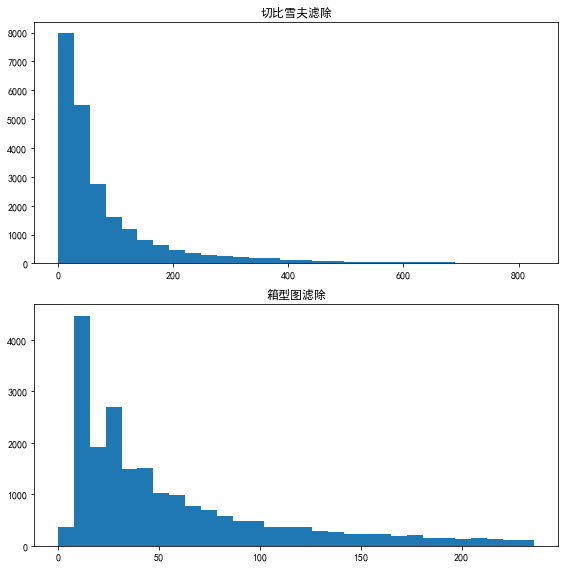

In [323]:
pylab.rcParams['figure.figsize']=(8,8)#8为长，10为宽
fig,ax = plt.subplots(2,1)
#根据切比雪夫定理，距离平均值有三个标准差的值均为异常值，即 106+241*3=829
ax[0].hist(user_grouped.query('amount<829')['amount'],bins=30)
ax[0].set_title('切比雪夫滤除')
#user_grouped.query('amount<829')['amount'].hist(bins=30)
#以箱型图Q3+1.5IQR为异常值截断点 106.5+1.5*（106.5-20）=236.25
ax[1].hist(user_grouped.query('amount<236.25')['amount'],bins=30)
ax[1].set_title('箱型图滤除')
plt.tight_layout() #合理填充界面

## 用户累积购买量

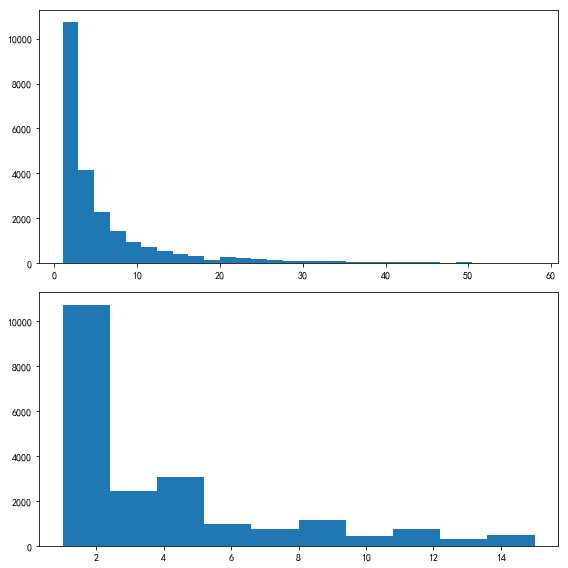

In [21]:
pylab.rcParams['figure.figsize']=(8,8)#8为长，10为宽
fig,ax = plt.subplots(2,1)
#根据切比雪夫定理，距离平均值有三个标准差的值均为异常值，
ax[0].hist(user_grouped.query('quantity<58.12')['quantity'],bins=30)
#user_grouped.query('amount<829')['amount'].hist(bins=30)
#以箱型图Q3+1.5IQR为异常值截断点 
ax[1].hist(user_grouped.query('quantity<16')['quantity'],bins=10)
plt.tight_layout() #合理填充界面

## 各用户购买金额累积贡献分析

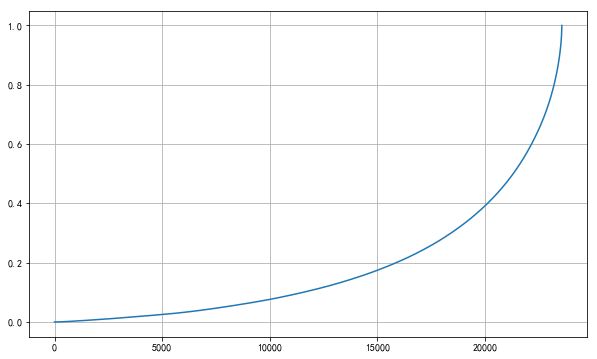

In [29]:
user_cumsum = user_grouped.sort_values('amount')
user_cumsum['amount_cumsum'] = user_cumsum.amount.cumsum()
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,len(user_cumsum)),user_cumsum['amount_cumsum']/user_cumsum['amount'].sum())
plt.grid()
plt.show()

# user_cumsum = user_grouped.sort_values('amount').apply(lambda x : x.cumsum()/x.sum())
# user_cumsum.reset_index(drop=True).amount.plot()
# plt.grid()

可以看到，排名前20000的用户(一共有23570人，即84.85%的用户)仅贡献了40%的消费金额

## 各用户购买数量累积贡献分析

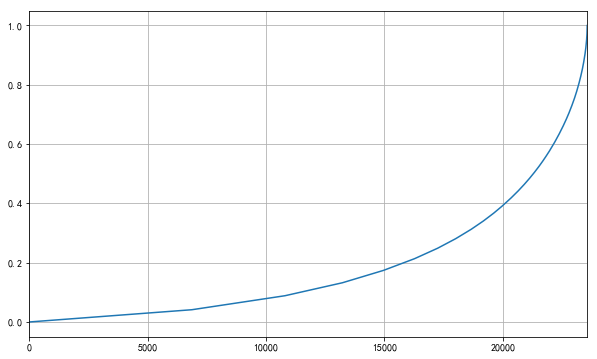

In [34]:
user_cumsum = user_grouped.sort_values('quantity').apply(lambda x : x.cumsum()/x.sum())
user_cumsum.reset_index(drop=True).quantity.plot(figsize=(10,6))
plt.grid()

## 各用户最大单笔购买数量以及最大单笔消费金额

In [35]:
#重新设置索引，按列的固定顺序
data = data.reset_index()[['id','date','quantity','amount']]
#各用户最大单笔购买数量以及最大单笔消费金额
print(data.groupby('id').max()[['quantity','amount']].head())
print('*'*20)

#各用户购买次数
print(data['id'].value_counts().head())
print(data.groupby('id').count()['quantity'].head())

    quantity  amount
id                  
1          1   11.77
2          5   77.00
3          5   57.45
4          2   29.73
5          4   46.46
********************
14048    217
7592     201
7983     149
22061    143
3049     117
Name: id, dtype: int64
id
1     1
2     2
3     6
4     4
5    11
Name: quantity, dtype: int64


# 三. 用户消费行为动态分析

## 各用户第一次购买时间以及最后一次购买时间

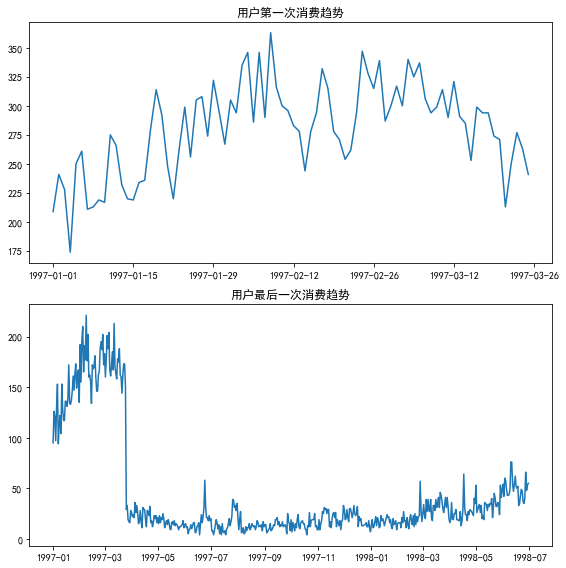

In [66]:
id_grouped = data.groupby('id')
#各用户第一次购买时间
first_buy = id_grouped['date'].min()
#各用户最后一次购买时间
last_buy = id_grouped['date'].max()

fig,ax = plt.subplots(2,1)
ax[0].plot(first_buy.value_counts().sort_index())
ax[0].set_title('用户第一次消费趋势')
ax[0].set_xticks(['1997-01-01','1997-01-15','1997-01-29','1997-02-12','1997-02-26','1997-03-12','1997-03-26'])
ax[0].set_xticklabels(['1997-01-01','1997-01-15','1997-01-29','1997-02-12','1997-02-26','1997-03-12','1997-03-26'])
ax[1].plot(last_buy.value_counts().sort_index())
ax[1].set_title('用户最后一次消费趋势')
plt.tight_layout()

## 生命周期（最后一次 - 第一次）

In [42]:
from datetime import datetime
now=datetime.now()
#最后一次消费与当前时间间隔
print((now-last_buy).head())
print('*'*20)
#生命周期
user_cycle=last_buy - first_buy
print(user_cycle.describe())
print('*'*20)

id
1   8182 days 17:13:03.163484
2   8171 days 17:13:03.163484
3   7670 days 17:13:03.163484
4   7837 days 17:13:03.163484
5   7815 days 17:13:03.163484
Name: date, dtype: timedelta64[ns]
********************
count                       23570
mean     134 days 20:55:36.987696
std      180 days 13:46:43.039788
min               0 days 00:00:00
25%               0 days 00:00:00
50%               0 days 00:00:00
75%             294 days 00:00:00
max             544 days 00:00:00
Name: date, dtype: object
********************


用户平均生命周期为134天，但中位数为0，证明大部分用户购买一次之后就再未消费

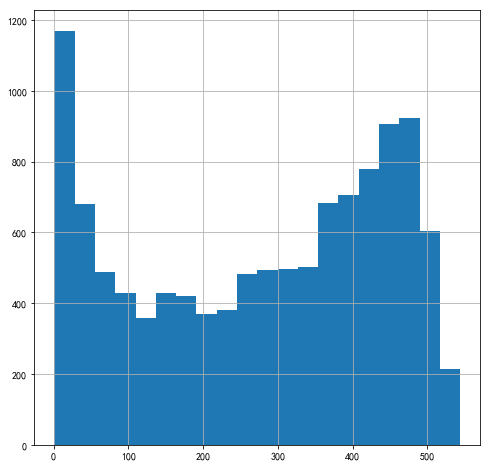

In [73]:
from datetime import timedelta
user_cycle = user_cycle/timedelta(1)
user_cycle[user_cycle>0].hist(bins=20)#滤除生命周期为0的用户

## 首次回购周期 

In [263]:
'''
思路：
每个用户原本的购买时间 - 每个用户第一次的购买时间
筛选>0的再挑选最小值
'''
date_min = id_grouped.date.min()
#suffxes参数是如果合并的内容中有重名column，加上后缀。
first_back = pd.merge(left = data, right = date_min.reset_index(),how = 'inner', on = 'id',suffixes = ('', '_min'))
first_back['date_diff'] = first_back.date - first_back.date_min
#将日期转化为时间
first_back['date_diff'] = first_back.date_diff.apply(lambda x: x/np.timedelta64(1,'D')) #日期转换为时间
first_back[first_back['date_diff']>0].groupby('id').min()['date_diff'].describe()

count    11516.000000
mean       110.995832
std        122.144701
min          1.000000
25%         18.000000
50%         57.000000
75%        171.000000
max        533.000000
Name: date_diff, dtype: float64

## 各用户平均购买周期

In [322]:
#按用户分组，计算用户本次购买日期和下一次购买日期的时间间隔
user_period = id_grouped.apply(lambda x:x.date-x.date.shift())
user_period.describe()

count                      46089
mean     68 days 23:22:13.567662
std      91 days 00:47:33.924168
min              0 days 00:00:00
25%             10 days 00:00:00
50%             31 days 00:00:00
75%             89 days 00:00:00
max            533 days 00:00:00
Name: date, dtype: object

求出用户的平均消费间隔时间是68天。想要召回用户，在68天左右的消费间隔是比较好的。

## 复购率和回购率：
- 复购率：自然月内，购买多次的用户占比
- 回购率：曾经购买过的用户在某一时期内再次购买的占比

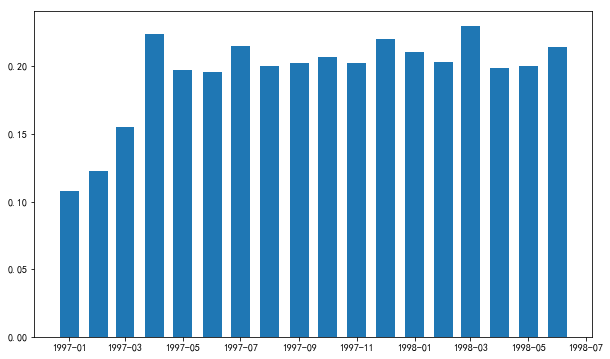

In [177]:
#import time
#转换成时间戳
# def timestamp(x):
#     x=time.strptime(x,'%Y%m')
#     x=int(time.mktime(x))
#     return x
#df.date=df.date.apply(timearray)

#复购率 尝试一下很傻的方法
df = data.reset_index(drop=True)
df.date=df.date.apply(lambda x:x.strftime(format='%Y%m'))#日期转str 改了格式 方便分组
df['date'] = pd.to_datetime(df['date'],format='%Y%m')  #str转日期 改了格式  下面有to_period转频率的方法
fugou_grouped = df.groupby(['date','id']).count()

x,y=[],[]
y_fenzi,y_fenmu,flag=0,0,0
for num,i in enumerate(fugou_grouped.index):
    #print(num,i[0],fugou_grouped.quantity[num])
    if i[0] not in x:
        x.append(i[0])
        if flag==1:
            y.append(y_fenzi/(y_fenzi+y_fenmu))
            y_fenzi,y_fenmu=0,0
        flag=1
        
    if fugou_grouped.quantity[num]>1:
        y_fenzi=y_fenzi+1
    else:
        y_fenmu=y_fenmu+1
        
    if num==len(fugou_grouped)-1:
        y.append(y_fenzi/(y_fenzi+y_fenmu))

params={
    'figure.figsize'   : '10, 6'
}
pylab.rcParams.update(params)

plt.bar(x,y,width=20)
plt.show()

## 复购率（透视表）

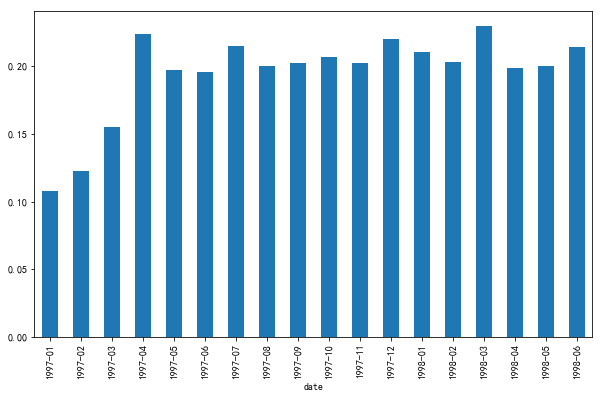

In [228]:
df = data.reset_index(drop=True)
df = df.set_index('date')
df = df.to_period(freq='M')#转换成月  上面的那种转成str再转datetime也可以
df = df.reset_index()

pivoted_count = df.pivot_table(index = 'id',
                               columns='date',
                               values = 'quantity',
                               aggfunc={'quantity':'count'})
pivoted_count = pivoted_count.fillna(0)#没有消费的先填充为0
df_purchase = pivoted_count.applymap(lambda x:1 if x>1 else np.nan if x==0 else 0)#清洗数据，消费超过两次为1，消费过1次为0，没有消费为nan
df_purchase.apply(lambda x:x.sum()/x.count()).plot.bar()

## 回购率
计算用户的回购率主要以本月与上月的进行对比，假如上月进行过消费，本月再次消费了，说明该用户是回购用户。

1. 末月不存在回购行为，因此其回购率为0；
2. 前三个月由于有大量新用户涌入，大部分人只消费过一次，所以两个月回购率偏低；
3. 第四个月回购率回升，最后稳定在35%左右，即当月消费人数中有30%左右的用户会在下一个月再次消费。

## 留存率
指用户第一次消费后，有多少比率进行第二次消费。和回流率区别是留存率并有多个时间窗口。

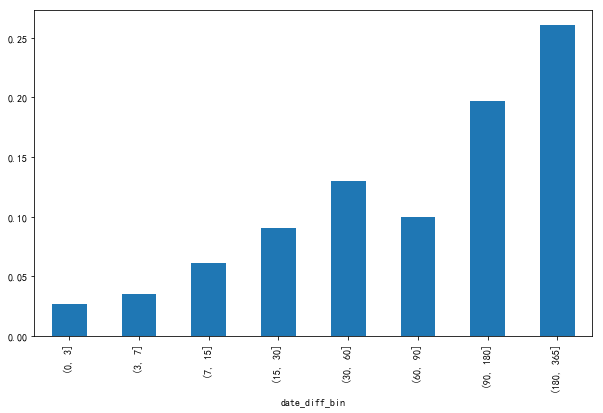

In [270]:
#利用首次回购日期的first_back
bin = [0,3,7,15,30,60,90,180,365]
first_back['date_diff_bin'] = pd.cut(first_back.date_diff, bins = bin)
pivoted_retention = first_back.pivot_table(index = 'id', columns = 'date_diff_bin',values = 'amount', aggfunc = sum, dropna = False)
pivoted_retention_trans = pivoted_retention.fillna(0).applymap(lambda x: 1 if x>0 else 0)
pivoted_retention_trans.mean().plot.bar()

# 用户分层

## 按用户价值分层---RFM模型：
1. 最近一次消费-R：客户最近一次交易时间的间隔。R值越大，表示客户交易发生的日期越久，反之则交易发生的日期越近。
2. 消费频率-F：客户在最近一段时间内交易的次数。F值越大，表示客户交易越频繁，反之则表示客户交易不够活跃。
3. 消费金额-M：客户在最近一段时间内交易的金额。M值越大，表示客户价值越高，反之则表示客户价值越低。
* 根据上述三个维度，对客户做细分

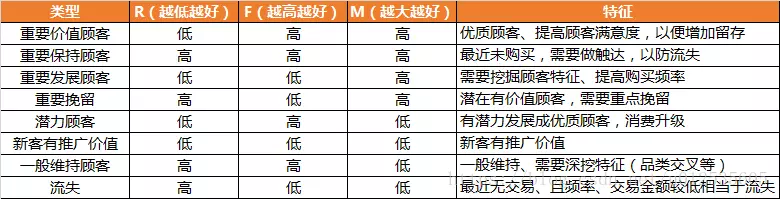

In [292]:
rfm = df.pivot_table(index = 'id',
                     values = ['date','quantity','amount'],
                     aggfunc = {'date':'max',
                                'quantity':'count',
                                'amount':'sum'})
rfm['R']=(rfm['date'].max() - rfm['date']) / timedelta(1)
rfm.rename(columns = {'amount':'M', 'quantity':'F'},inplace=True)
rfm=rfm[['R','F','M']]
rfm.head()

,R,F,M
id,,,
1,545.0,1,11.77
2,534.0,2,89.00
3,33.0,6,156.46
4,200.0,4,100.50
5,178.0,11,385.61


将用户在R、F、M
三个维度上按照高于平均值和低于平均值进行划分（划分标准可根据不同业务设计也不同）,高于平均值则赋值为1，低于平均值则赋值为0，最后根据RFM分层模型给所有用户分层：

In [293]:
def level_label(data):
    level = data.apply(lambda x:'1' if x>0 else '0')
    label = level['R']+level['F']+level['M']
    d = {
        
        '011':"高价值客户",
        '111':"重点保持客户",
        '001':"重点发展客户",
        '101':"重点挽留客户",
        '010':"潜在客户",
        '000':"新客有推广价值",
        '110':"一般保持客户",
        '100':"流失"
    }
    result = d[label]
    return result

rfm['label']=rfm.apply(lambda x:x-x.mean()).apply(level_label,axis=1)
print(rfm.groupby('label').sum())

                 R      F           M
label                                
一般保持客户    237754.0   1782    36200.21
新客有推广价值   311519.0   3064    75781.48
流失       6750356.0  15589   409272.88
潜在客户      309037.0   7371   141127.20
重点保持客户    194091.0   1950   103260.14
重点发展客户     56855.0    536    46158.16
重点挽留客户    278754.0    877    96849.09
高价值客户     517048.0  38490  1591666.47


# 按用户活跃程度分层---新用户、活跃用户、不活跃用户、回流用户
1. 新用户的定义是第一次消费。
2. 活跃用户即老客，在某一个时间窗口内有过消费。
3. 不活跃用户则是时间窗口内没有消费过的老客。
4. 回流用户是在上一个窗口中没有消费，而在当前时间窗口内有过消费。

In [308]:
pivoted_count.head()

date,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06
id,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


进行多重判断，将用户状态分为unreg（未注册）、new（新客）、active（活跃用户）return（回流用户）和unactive（不活跃用户）：

In [317]:
def avtive_status(data):
    status=[]
    for i in range(18): #18个月
        #若当前月有消费
        if data[i]>0:  
            #第一个月就有消费
            if len(status)==0:
                status.append('new')  #新用户    
            else:
                #上个月是未注册状态（之前都是未注册状态）
                if status[i-1]=='unreg':
                    status.append('new') #新用户
                #上个月未消费，但再上个月以及之前有过消费，就是上个月是unactive
                elif status[i-1]=='unactive':
                    status.append('return') #回流
                #上个月有消费，不管是new、active还是return
                else:
                    status.append('active') #活跃
        #当前月未消费
        else:
            if len(status)==0:
                status.append('unreg')  #未注册   
            else:
                #上个月是未注册状态（之前都是未注册状态）
                if status[i-1]=='unreg':
                    status.append('unreg') #未注册
                #上个月有消费，不管是new、unactive、active还是return
                else:
                    status.append('unactive') #活跃
                    
    return status

active_count = pivoted_count.apply(lambda x:pd.Series(avtive_status(x),index=pivoted_count.columns),axis=1)
print(active_count.head())

date 1997-01   1997-02   1997-03   1997-04   1997-05   1997-06   1997-07  \
id                                                                         
1        new  unactive  unactive  unactive  unactive  unactive  unactive   
2        new  unactive  unactive  unactive  unactive  unactive  unactive   
3        new  unactive    return    active  unactive  unactive  unactive   
4        new  unactive  unactive  unactive  unactive  unactive  unactive   
5        new    active  unactive    return    active    active    active   

date   1997-08   1997-09   1997-10   1997-11   1997-12   1998-01   1998-02  \
id                                                                           
1     unactive  unactive  unactive  unactive  unactive  unactive  unactive   
2     unactive  unactive  unactive  unactive  unactive  unactive  unactive   
3     unactive  unactive  unactive    return  unactive  unactive  unactive   
4       return  unactive  unactive  unactive    return  unactive  unactive   

In [321]:
df_count=active_count.replace('unreg',np.NaN).apply(lambda x:pd.value_counts(x)).fillna(0).T
print(df_count)
df_rate = df_count.apply(lambda x:x/x.sum(),axis=1)
print(df_rate)

         active     new  return  unactive
date                                     
1997-01     0.0  7846.0     0.0       0.0
1997-02  1157.0  8476.0     0.0    6689.0
1997-03  1681.0  7248.0   595.0   14046.0
1997-04  1773.0     0.0  1049.0   20748.0
1997-05   852.0     0.0  1362.0   21356.0
1997-06   747.0     0.0  1592.0   21231.0
1997-07   746.0     0.0  1434.0   21390.0
1997-08   604.0     0.0  1168.0   21798.0
1997-09   528.0     0.0  1211.0   21831.0
1997-10   532.0     0.0  1307.0   21731.0
1997-11   624.0     0.0  1404.0   21542.0
1997-12   632.0     0.0  1232.0   21706.0
1998-01   512.0     0.0  1025.0   22033.0
1998-02   472.0     0.0  1079.0   22019.0
1998-03   571.0     0.0  1489.0   21510.0
1998-04   518.0     0.0   919.0   22133.0
1998-05   459.0     0.0  1029.0   22082.0
1998-06   446.0     0.0  1060.0   22064.0
           active       new    return  unactive
date                                           
1997-01  0.000000  1.000000  0.000000  0.000000
1997-02  0.07088

- 从表中可以看出，新客都是集中在前三个月，回流用户整体在1000左右，而不活跃用户数量随时间稍有上升。

- 新客用户：仅在前三个月，后续再无新增客户。
- 活跃用户：比例持续下降，说明持续消费的用户数量在减少，也说明运营部门的促活效果并不好。
- 回流用户：比例也稍有下降，在4%左右波动。
- 不活跃用户：比例稍有上升，流失较大。